In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

# Exponential function: $u(t,x)=(x+bt)exp(at)$
The function $u$ solves only $u_t=au+bu_x$.

In [2]:
a = 1
b = 2
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

u = (xv + b*tv) * np.exp(a*tv)

dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,drop_endpoints=False)._differentiate(u, dx)

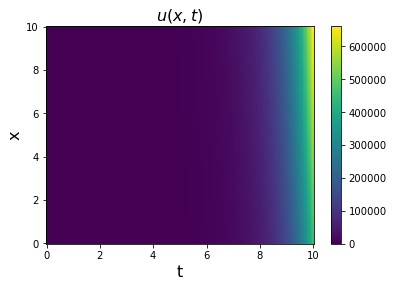

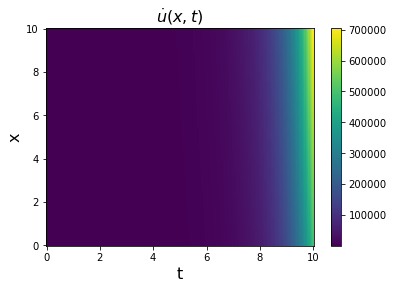

In [3]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

In [4]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x]
library_function_names = [lambda x: x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = -4.567 1 + 1.001 x0 + 2.000 x0_1
SR3 model, L0 norm: 
(x0)' = -4.567 1 + 1.001 x0 + 2.000 x0_1
SR3 model, L1 norm: 
(x0)' = -4.567 1 + 1.001 x0 + 2.000 x0_1
SSR model: 
(x0)' = 1.000 x0 + 2.010 x0_1
SSR (metric = model residual) model: 
(x0)' = 316.644 1 + 1.081 x0
FROLs model: 
(x0)' = 1.082 x0


Weirdly onyl some algorithms find the correct terms and some even add weird intercepts.
## Check the rank of the matrix, as we have uniqueness for linear PDEs
We cannot directly check the matrix rank of $(u(t_i,x_j),u_x(t_i,x_j))(\mathbb{R}^{n\times m})^2$ as both are themselves already matrices or even higher dimensional linear forms. Linear dependence of the function is equal to linear dependence of the matrices, which translates to linear dependence of the vectorized versions of $(u(t_i,x_j),u_x(t_i,x_j))\in\mathbb{R}^{nm\times2}$.

In [5]:
from numpy.linalg import matrix_rank, svd

In [6]:
ux = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux.flatten()
g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
matrix_rank(g), svd(g, compute_uv=False)

(2, array([29936543.58028654,   155799.23376726]))

In [7]:
distance_svs = []
fd_orders = range(2, 8)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat = u.flatten(), ux.flatten()
    features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
    svs = svd(features, compute_uv=False)
    distance_svs.append(svs[-1])

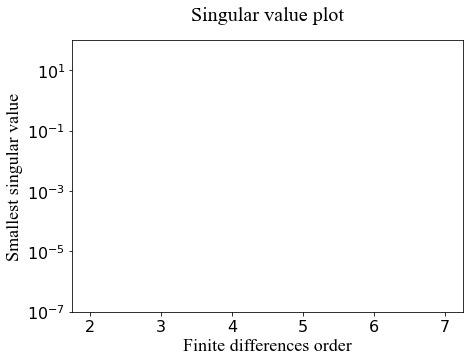

In [8]:
# Journal paper
titlesize = 20
labelsize = titlesize - 2
tickssize = labelsize - 2
plt.figure(figsize=(7,5))
plt.plot(range(2,8), distance_svs, linewidth=2.3)
plt.title('Singular value plot', size=titlesize, fontname="Times New Roman", y=1.05)
plt.xlabel('Finite differences order', size=labelsize, fontname="Times New Roman")
plt.ylabel('Smallest singular value', size=labelsize, fontname="Times New Roman")
plt.ylim((10**(-7),10**2))
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.yscale('log')
plt.savefig(r'D:\OneDrive\Dokumente\Uni\Doktor\Paper\Projects\Physical Law Learning\Images\Experiments\Uniqueness\SV_Plot_linear_PDE_unique.eps', format='eps')

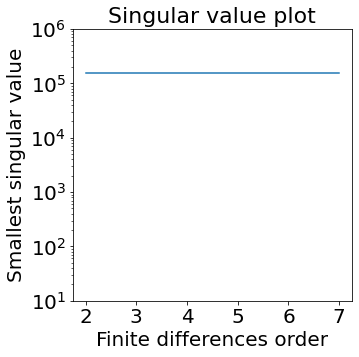

In [10]:
# Conference paper
titlesize = 22
labelsize = titlesize - 2
tickssize = labelsize
plt.figure(figsize=(5,5))
plt.plot(range(2,8), distance_svs)
plt.title('Singular value plot', size=titlesize)
plt.xlabel('Finite differences order', size=labelsize)
plt.ylabel('Smallest singular value', size=labelsize)
plt.ylim((10,10**6))
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.yscale('log')
results_path = r'D:\OneDrive\Dokumente\Uni\Doktor\Paper\Projects\Physical Law Learning\ICASSP\Images'
plt.savefig(os.path.join(results_path, 'linear_unique.svg'))

## Regression check
Another possibility is to perform a regression with one of the variables as the dependent one, to basically find the linear relation. This is only possible that easy if it is only 2 variables, otherwise it is not given that both have to have a non-zero coefficient when looking at the linear function mapping all variables to 0. The fitness can be shown by using the R squared curve.

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(ux.flatten().reshape(-1, 1), u.flatten())
reg.coef_

array([24.29756745])

In [10]:
scores = []
distances = []
fd_orders = range(2, 8)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
    reg = LinearRegression().fit(ux.flatten().reshape(-1, 1), u.flatten())
    scores.append(reg.score(ux.flatten().reshape(-1, 1), u.flatten()))
    distances.append(reg.predict)

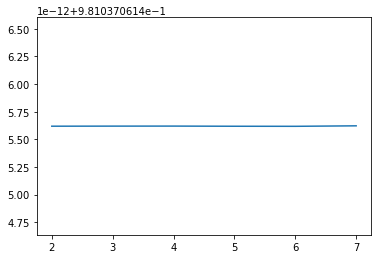

In [11]:
plt.plot(range(2,8), scores)

Weirdly, the regression check shows a strong correlation between $u$ and $u_x$. Possibly because the exponential is dominating the change?